In [1]:
import os
import sys
import time

import numpy as np

from pstools.rambo import dot

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras import activations

from keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping
# NB .legacy below something specific to M1/M2 Apple chips 
#from keras.optimizers.legacy import Adam
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

2023-11-26 15:05:09.024501: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 15:05:09.125400: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 15:05:09.126744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 15:05:10.411633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Error estimates for Neural Networks  ##

The sqaured scattering amplitude (summed and averaged over colour) for $e^+e^- \to$ jets have been evaluated over a flat phase-space generated with the RAMBO algorithm. Various phase-space cuts for the separation of final state 'jets' have been applied using the JADE algorithm. Tree/zero-loop '0L' ($|A^{(0)}|^2$) and one-loop ($2{\rm Re}(A^{(0)*}A^{(1)}|$) amplitudes have been compute using the NJet C++ library (https://bitbucket.org/njet/njet/wiki/Home)

The data consists of 1M phase-space points for processes with 3 or 4 final state jets. The data is given in numpy '.npz' format generated using the 'numpy.savez' command and are labelled as

<code>data/NJdata_\<loop order\>_ee\<n\>j_d\<jade cut\>.npz</code>

where loop order=0L,1L, n=3,4 and jade cut=0.03, 0.02 and 0.01
    
The data is available from: 
    
which should be unpacked into the same directory as the notebook.

# Aim #

To use an ensemble of neural networks with different initialization parameters to make an error estimate of the amplitude fit.
    
We will test how well the standard deviation of the network ensemble agrees with the true error based on a test data set.

# Step 1: Choose process and select training data

In [2]:
loop = 0
jets = 3
delta_cut = 0.01

In [3]:
NJdata = np.load("data/NJdata_"+str(loop)+"L_ee"+str(jets)+"j_d"+str(delta_cut)+".npz")
print(NJdata.files)

mom_data = NJdata['momenta']
amp_data = NJdata['NJ_vals']

['momenta', 'NJ_vals']


In [4]:
# choose the number of training points (will later be split into NN train/validation set)
n_points = len(amp_data)
print("found", n_points, "data points")

n_training_points = 50000
# choose the number of points for interpolation tests after training
# NB - different from the training/validation split during training
n_test_points = min(800000, n_points-n_training_points)

print("will train/validate on",n_training_points,"then test on",n_test_points)

found 1000000 data points
will train/validate on 50000 then test on 800000


In [5]:
mom_train = mom_data[:n_training_points]
amp_train = amp_data[:n_training_points]

In [6]:
def mean_and_std(myarray, axis=0):
    return np.mean(myarray, axis=axis), np.std(myarray, axis=axis)

In [7]:
def standardize(myarray, ave, std):
    return (myarray-ave)/std

def destandardize(myarray, ave, std):
    return myarray*std+ave

In [8]:
def logstandardize(myarray, std):
    return np.log(1.+myarray/std)

def logdestandardize(myarray, std):
    return (np.exp(myarray)-1.)*std

# Setup and train set of models

In [9]:
# another option is to use the 3*n-10 independent invariants as input
# this attempts to account for the Poincare' redundancy in the Lorentz vector representation
def momenta2invariants(mm):
    if len(mm)==4: # s,t
        invariants = 2.*np.array([
            dot(mm[0], mm[1]),dot(mm[1], mm[2])])
    elif len(mm)==5: # s12,s23,s34,s45,s15
        invariants = 2.*np.array([
            dot(mm[0], mm[1]),dot(mm[1], mm[2]),
            dot(mm[2], mm[3]),dot(mm[3], mm[4]),
            dot(mm[4], mm[0])])
    elif len(mm)==6: # s12,s23,s34,s45,s56,s16,s123,s234
        invariants = 2.*np.array([
            dot(mm[0], mm[1]),dot(mm[1], mm[2]),
            dot(mm[2], mm[3]),dot(mm[3], mm[4]),
            dot(mm[4], mm[5]),dot(mm[5], mm[0]),
            dot(mm[0], mm[1])+dot(mm[1], mm[2])+dot(mm[0], mm[2]),
            dot(mm[1], mm[2])+dot(mm[2], mm[3])+dot(mm[1], mm[3])
        ])
    else:
        print("only n = 4,5,6 implemented")
        
    return invariants
        

In [10]:
inv_train = np.array([momenta2invariants(mm) for mm in mom_train])

In [11]:
amp_threshold = np.sort(amp_train)[-int(len(amp_train)*0.001)]
amp_threshold2 = np.sort(amp_train)[-int(len(amp_train)*0.01)]

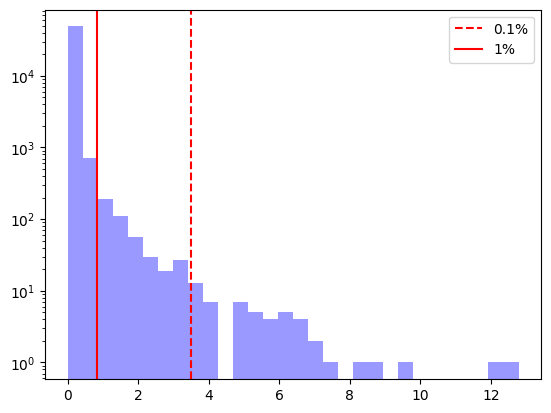

In [12]:
mybins = np.histogram_bin_edges(np.abs(amp_train), bins=30, range=(0,np.max(amp_train)))
plt.hist(amp_train, density=False, bins=mybins, color='b', alpha=0.4, log=True)
plt.axvline(x=amp_threshold, color='red', linestyle='--', label='0.1%')
plt.axvline(x=amp_threshold2, color='red', linestyle='-', label='1%')
plt.legend()

In [13]:
large_indices = np.where(np.logical_or(amp_train>amp_threshold2,amp_train<-amp_threshold2))
very_large_indices = np.where(np.logical_or(amp_train>amp_threshold,amp_train<-amp_threshold))

In [14]:
amp_train_boosted = amp_train
inv_train_boosted = inv_train

for ii in range(8):
    amp_train_boosted = np.concatenate((amp_train_boosted, amp_train[large_indices]), axis=0)
    inv_train_boosted = np.concatenate((inv_train_boosted, inv_train[large_indices]), axis=0)

for ii in range(32):
    amp_train_boosted = np.concatenate((amp_train_boosted, amp_train[very_large_indices]), axis=0)
    inv_train_boosted = np.concatenate((inv_train_boosted, inv_train[very_large_indices]), axis=0)

print(len(amp_train_boosted))

55560


In [15]:
# as we are have e+e- with fixed centre-of-mass energy the
# invariant (p0+p1)^2 = 2*p0.p1 is constant and can be eliminated
inv_ave, inv_std = mean_and_std(inv_train_boosted[:,1:],axis=0)
inv_stdized = standardize(inv_train_boosted[:,1:], inv_ave, inv_std)

In [16]:
# the standardized the amplitude values as well
amp_ave = np.mean(amp_train_boosted)
amp_std = np.std(amp_train_boosted)
amp_stdized = standardize(amp_train_boosted,amp_ave,amp_std)
#amp_stdized = logstandardize(amp_train_boosted,amp_std)

In [17]:
def model_init(inv_stdized, layers):
    input_size = len(inv_stdized[0])
    input_values = inv_stdized

    model = Sequential()

    model.add(Dense(
        layers[0], input_dim=(input_size), kernel_initializer = glorot_uniform(seed=1)
    ))
    model.add(Activation(activations.tanh))
        
    for layer in range(1, len(layers)):
        model.add(Dense(layers[layer]))
        model.add(Activation(activations.tanh))

    model.add(Dense(
        1, kernel_initializer = glorot_uniform(seed=len(layers))
        ))
    # Compile model
    model.compile(
        optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
        loss = 'mean_squared_error'
    )
    return model

In [18]:
model = []
n_ensemble = 20
for mm in range(n_ensemble):
    model.append(model_init(inv_stdized, [20,40,20]))

In [19]:
ES = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=100,
    verbose=1,
    restore_best_weights=True
)

In [20]:
history = []
for mm in range(n_ensemble):
    
    print('starting training of model', mm);
    start_time = time.time();
    
    input_train, input_val, output_train, output_val = train_test_split(
        inv_stdized, amp_stdized, test_size=0.2)
    
    history.append(model[mm].fit(
        input_train, output_train,
        validation_data=(input_val, output_val),
        batch_size=1024,
        epochs=10000,
        verbose=0,
        shuffle=False,
        callbacks=[ES]
    ))

    print(f'Best case loss: {ES.best}')
    
    print('finished in ', time.time()-start_time)

starting training of model 0
Restoring model weights from the end of the best epoch: 1355.
Epoch 1455: early stopping
Best case loss: 0.00015145943325478584
finished in  258.5138804912567
starting training of model 1
Restoring model weights from the end of the best epoch: 346.
Epoch 446: early stopping
Best case loss: 0.002110855421051383
finished in  80.24817228317261
starting training of model 2
Restoring model weights from the end of the best epoch: 1229.
Epoch 1329: early stopping
Best case loss: 7.255136006278917e-05
finished in  244.43138909339905
starting training of model 3
Restoring model weights from the end of the best epoch: 706.
Epoch 806: early stopping
Best case loss: 0.0006728924345225096
finished in  150.46031022071838
starting training of model 4
Restoring model weights from the end of the best epoch: 277.
Epoch 377: early stopping
Best case loss: 0.0017139335395768285
finished in  68.23589277267456
starting training of model 5
Restoring model weights from the end of 

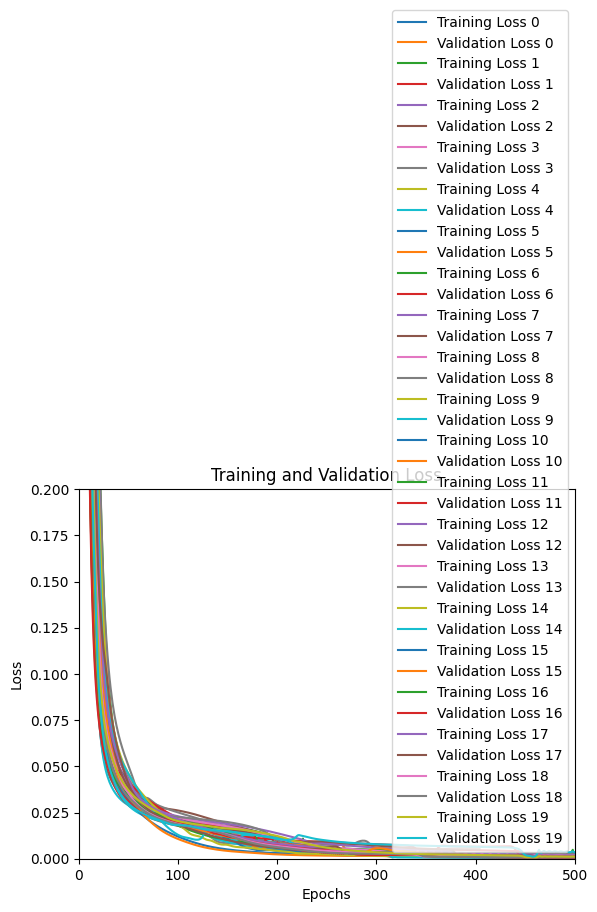

In [21]:
# Access the loss values from the training history.
for mm in range(n_ensemble):
    train_loss = history[mm].history['loss']
    val_loss = history[mm].history['val_loss']

    # Create a plot of the training and validation loss over epochs.
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Training Loss '+str(mm))
    plt.plot(epochs, val_loss, label='Validation Loss '+str(mm))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,0.2)
plt.xlim(0,500)
plt.legend()

In [22]:
mom_test = mom_data[n_training_points:n_training_points+n_test_points]
amp_test = amp_data[n_training_points:n_training_points+n_test_points]

In [23]:
inv_test = np.array([momenta2invariants(mm) for mm in mom_test])
inv_test_stdized = standardize(inv_test[:,1:], inv_ave, inv_std)

In [24]:
amp_preds = [np.array(
    destandardize(model[mm].predict(inv_test_stdized), amp_ave, amp_std)
).reshape(-1) for mm in range(n_ensemble)]

25000/25000 [==============================] - 30s 1ms/step


In [25]:
amp_pred = np.mean(amp_preds,axis=0)
amp_pred_err = np.std(amp_preds,axis=0)

In [26]:
acc = 2.*(amp_pred-amp_test)/(amp_pred+amp_test)

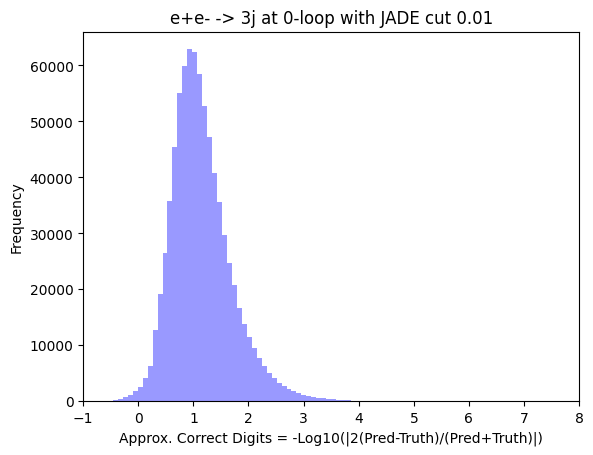

In [27]:
logacc = -np.log10(abs(acc))

mybins = np.histogram_bin_edges(logacc, bins=100, range=(-1,8))
plt.hist(logacc, density=False, bins=mybins, color='b', alpha=0.4)
plt.xlim([-1,8])
plt.title(r'e+e- -> '+str(jets)+'j at '+str(loop)+'-loop with JADE cut '+str(delta_cut))
plt.xlabel('Approx. Correct Digits = -Log10(|2(Pred-Truth)/(Pred+Truth)|)')
plt.ylabel('Frequency');

In [28]:
outtest = np.transpose(np.array([amp_test,np.abs(amp_pred-amp_test),amp_pred_err]))

In [29]:
amp_test[0] ,np.abs(amp_pred[0]-amp_test[0]),amp_pred_err[0]

(0.10996499824972461, 0.0022292451903374033, 0.009923084)

In [30]:
outtest_sample = outtest[np.random.choice(outtest.shape[0], size=2000, replace=False)]

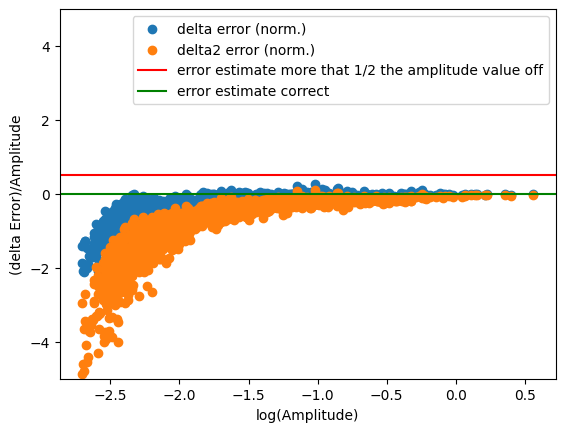

In [31]:
plt.scatter(np.log10(outtest_sample[:,0]),(outtest_sample[:,1]-outtest_sample[:,2])/outtest_sample[:,0],label='delta error (norm.)')
plt.scatter(np.log10(outtest_sample[:,0]),(outtest_sample[:,1]-2.*outtest_sample[:,2])/outtest_sample[:,0],label='delta2 error (norm.)')
plt.axhline(y=0.5, c='r', label='error estimate more that 1/2 the amplitude value off')
plt.axhline(y=0, c='g', label='error estimate correct')
plt.ylim([-5,5])
plt.xlabel('log(Amplitude)')
plt.ylabel('(delta Error)/Amplitude')
plt.legend()

In [32]:
bad = outtest_sample[outtest_sample[:,1]>2.*outtest_sample[:,2]]

In [33]:
len(bad)/len(outtest_sample)

0.002

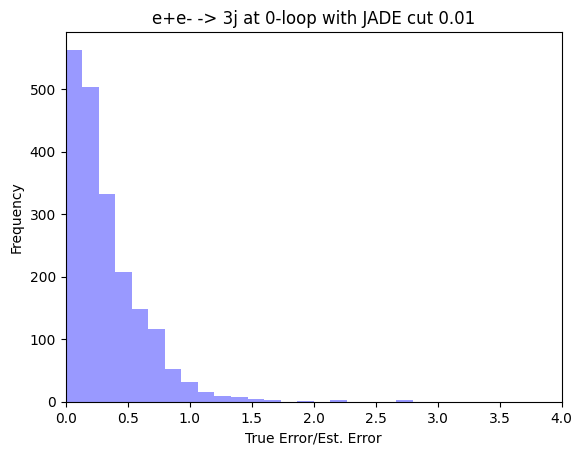

In [34]:
err_ratio = outtest_sample[:,1]/outtest_sample[:,2]
mybins = np.histogram_bin_edges(err_ratio, bins=30, range=(0,4))
plt.hist(err_ratio, density=False, bins=mybins, color='b', alpha=0.4)
plt.xlim([0,4])
plt.title(r'e+e- -> '+str(jets)+'j at '+str(loop)+'-loop with JADE cut '+str(delta_cut))
plt.xlabel('True Error/Est. Error')
plt.ylabel('Frequency');